In [1]:
import pandas as pd
from src.plot import plot_img_row
from src.stimuli import MNISTM,MNISTAugmented,FashionMNISTM,FashionMNISTM

Using TensorFlow backend.


In [2]:
import os
import random
import json
import hashlib
import numpy as np
import pandas as pd
import xarray
import neptune
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from tqdm import tqdm as tqdm
import multiprocessing as mp

from sklearn.linear_model import LinearRegression,Ridge,RidgeCV

import brainscore
from brainscore.assemblies import walk_coords,split_assembly
from brainscore.assemblies import split_assembly
# from brainscore.metrics import Score

from brainio_base.assemblies import DataAssembly

from scipy.stats import pearsonr

# from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime, save_assembly
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies,NeptuneExperimentRun
from src.results.dicarlo import load_md_images,process_dicarlo
from src.data_loader import Shifted_Data_Loader
from src.stimuli import MNISTM

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Palatino", "serif"]
    })

In [ ]:
DB = FashionMNISTM(bg_scale=4,rotation=0.3,translation=0.75,bg_contrast=0.5)
batches = DB.gen_eval_batches(1,10000,)
images,y,metadata = next(batches)

In [19]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')

Project(elijahc/DuplexAE)

In [4]:
proj_root = '/home/elijahc/projects/vae'

In [ ]:
# exps = neptune.project.get_experiments(id=['DPX-64','DPX-65'])
exps = neptune.project.get_experiments(id=['DPX-66'])

In [ ]:
# exps = neptune.project.get_experiments(id=['DPX-45','DPX-59','DPX-61'])
# mod = next(load_models(proj_root,exps))

In [ ]:
# runs = [NeptuneExperimentRun(proj_root,e) for e in exps]
# assemblies = [next(r.load_assemblies()) for r in runs]
# assemblies

In [5]:
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()
stimulus_set = neural_data.attrs['stimulus_set']
# # stimulus_set.to_csv('../data/dicarlo_images/stimulus_set.csv',index=False)
neural_data = process_dicarlo(neural_data)
dicarlo_metadata = stimulus_set[['image_id','object_name','category_name','variation','dy_px','dx_px','rxy']].rename(columns={'dx_px':'dx','dy_px':'dy'})

md_images = load_md_images(proj_root)

In [18]:
dicarlo_metadata.iloc[5]

image_id         c6fb4f35719f0f205f5ad65f4fd2794212c5d139
object_name                                     airplane7
category_name                                      Planes
variation                                               0
dy                                                      0
dx                                                      0
rxy                                                    -0
Name: 5, dtype: object

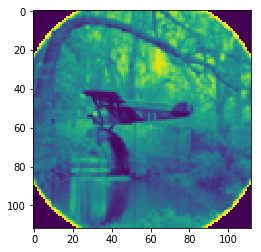

In [16]:
plt.imshow(md_images[5])

In [ ]:
# for e in exps:
#     exp_dir = os.path.join(proj_root,e.get_properties()['dir'])
#     PARAMS = e.get_parameters()
#     PROPS = e.get_properties()
#     run = NeptuneExperimentRun(proj_root,e)
    
#     xr = run.gen_assembly(test_data=images['whole'], n_units=300, metadata=metadata,seed=7)
#     xr.name = 'fashion_mnist'
#     print('saving fashion mnist assembly...')
#     save_assembly(xr,exp_dir,fname='{}.{}.nc'.format(xr.name,run.name))
    
#     xr = run.gen_assembly(test_data=md_images, n_units=300, metadata=dicarlo_metadata,seed=7)
#     xr.name = 'dicarlo'

#     save_assembly(xr,exp_dir,fname='{}.{}.nc'.format(xr.name,run.name))

In [ ]:
# np.save(os.path.join(r.experiment_dir,'fashion_mnist.DPX-66.stimuli'),images['whole'])

In [ ]:
# neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
# neural_data.load()
# stimulus_set = neural_data.attrs['stimulus_set']

In [ ]:
# def process_dicarlo(assembly,avg_repetition=True,variation=3,tasks=['ty','tz','rxy']):
#     stimulus_set = assembly.attrs['stimulus_set']
#     stimulus_set['dy_deg'] = stimulus_set.tz*stimulus_set.degrees
#     stimulus_set['dx_deg'] = stimulus_set.ty*stimulus_set.degrees
#     stimulus_set['dy_px'] = stimulus_set.dy_deg*32
#     stimulus_set['dx_px'] = stimulus_set.dx_deg*32
    
#     assembly.attrs['stimulus_set'] = stimulus_set
    
#     data = assembly.sel(variation=variation)
#     groups = ['category_name', 'object_name', 'image_id']+tasks
#     if not avg_repetition:
#         groups.append('repetition')
        
#     data = data.multi_groupby(groups)     # (2)
#     data = data.mean(dim='presentation')
#     data = data.squeeze('time_bin')    #   (3)
#     data.attrs['stimulus_set'] = stimulus_set.query('variation == {}'.format(variation))
#     data = data.T
    
#     return data

In [ ]:
# pos_samples = .where(lg_both.numeric_label==1,drop=True).values[:,250]
# neg_samples = lg_both.where(lg_both.numeric_label!=1, drop=True).values[:,250]

In [ ]:
def xr_exclude_zero_dim(da,neuroid_coord):
    nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
    return da[:,nz_neuroids]

In [ ]:
from brainscore.metrics import Score

In [ ]:
def SUCorrelation(da,neuroid_coord,correlation_vars,exclude_zeros=True,progress=True):
    if exclude_zeros:
        nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
        da = da[:,nz_neuroids]
    
    correlations = np.empty((len(da[neuroid_coord]),len(correlation_vars)))
    iterator = enumerate(da[neuroid_coord].values)
    if progress:
        iterator = tqdm(iterator,
                        total=len(da[neuroid_coord]),
                        mininterval=5,desc='pearsonr'
                       )
    
    for i,nid in iterator:
        for j,prop in enumerate(correlation_vars):
            n_act = da.sel(**{neuroid_coord:nid}).squeeze()
            r,p = pearsonr(n_act,prop)
            correlations[i,j] = np.abs(r)

    neuroid_dim = da[neuroid_coord].dims
    c = {coord: (dims, values) for coord, dims, values in walk_coords(da) if dims == neuroid_dim}
    c['task']=('task',[v.name for v in correlation_vars])
#     print(neuroid_dim)
    result = Score(correlations,
                       coords=c,
                       dims=('neuroid','task'))
    return result

def SUDprime(da,neuroid_coord='neuroid_id',class_coord='numeric_label',exclude_zeros=True,filters={},progress=True):    
    if exclude_zeros:
        nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
        da = da[:,nz_neuroids]
    if len(filters.items()) > 0:
        filts = [da[k].isin(v).values for k,v in filters.items()]
        if len(filts) > 1:
            logics = np.logical_or(*filts)
        else:
            logics = filts[0]
        da = da[:,logics]
    
    def cat_parts(da,class_coord):
        out = [np.concatenate([da[(da[class_coord]==c).values].values,da[(da[class_coord]!=c).values]],axis=0) for c in class_vals]
        return np.array(out)

    def dprime_1d(vec,cut=1000):
        return dprime(A=vec[:cut],B=vec[cut:],mode='sample',max_value=1,min_value=-1)
    
#     class_vals = np.unique(da[class_coord].values)
#     parts = [((da[class_coord]==c).values,(da[class_coord]!=c).values) for c in class_vals]
    class_vals = np.unique(da[class_coord].values)

    c_parts = cat_parts(da,class_coord)
    dprimes = np.empty((len(da[neuroid_coord]),len(class_vals)))
    iterator = enumerate(da[neuroid_coord].values)
    if progress:
        iterator = tqdm(iterator,
                        total=dprimes.shape[0],mininterval=5,
                        desc='dprime',
                       )

    for i,nid in iterator:
#         da_n = da.sel(**{neuroid_coord:nid})
        dpn = np.apply_along_axis(dprime_1d,1,c_parts[:,:,i])
        dprimes[i] = dpn

    neuroid_dim = da[neuroid_coord].dims
    c = {coord: (dims, values) for coord, dims, values in walk_coords(da) if dims == neuroid_dim}
    c['task']=('task',[class_coord])
#     print(neuroid_dim)
    result = Score(dprimes.max(axis=1).reshape(-1,1),
                       coords=c,
                       dims=('neuroid','task'))
    return result

def result_to_df(SUC,corr_var_labels):
    df = SUC.neuroid.to_dataframe().reset_index()
    for label in corr_var_labels:
        df[label]=SUC.sel(task=label).values
    
    return df

In [ ]:
def cat_parts(da,class_coord):
    class_vals = np.unique(da[class_coord].values)
    out = [np.concatenate([da[(da[class_coord]==c).values].values,da[(da[class_coord]!=c).values]],axis=0) for c in class_vals]
    return out

def dprime_1d(vec,cut=1000):
    return dprime(A=vec[:cut],B=vec[cut:],mode='sample',max_value=1,min_value=-1)

In [ ]:
def gu_SUD(da_sets,neuroid_coord):
    pool = mp.Pool(6)
    results = [pool.apply(SUDprime,args=(da,neuroid_coord)) for da in da_sets]
    pool.close()
    pool.join()
    return results

In [ ]:
def process_assembly(da,class_coords=['numeric_label'],r_vars=['tx','ty','rxy'],filters={},progress=True,exclude_zeros=True):
    # Calculate dprime for single units
    print('Calculating dprime all units...')
    if len(filters.items()) > 0:
        filts = [da[k].isin(v).values for k,v in filters.items()]
        if len(filts) > 1:
            logics = np.logical_or(*filts)
        else:
            logics = filts[0]
        da = da[:,logics]
    
    df_dps = []
    for class_coord in class_coords:
        print('- dprime of {}...'.format(class_coord))
        SUdp_score = SUDprime(da,neuroid_coord='neuroid_id',class_coord=class_coord,progress=progress,exclude_zeros=exclude_zeros)
        df_dps.append(result_to_df(SUdp_score,[class_coord]).sort_values(by='neuroid_id'))
    
    corr_vars = [pd.Series(da[v].values,name=v) for v in r_vars]
    print('Calculating pearsonr of all units...')
    corr = SUCorrelation(da,neuroid_coord='neuroid_id',correlation_vars=corr_vars,exclude_zeros=exclude_zeros)
    su_df = result_to_df(corr,r_vars).sort_values(by='neuroid_id')
    for dfdp,cc in zip(df_dps,class_coords):
        su_df = su_df.merge(dfdp[['neuroid_id',cc]],on='neuroid_id')
#     df_dp = df_dp.sort_values(by='neuroid_id').reset_index().drop(columns='index')
#     su_df = su_df.reset_index().drop(columns='index')
#     su_df['category'] = df_dp.category

    return su_df

In [ ]:
dfs = []
# names = ['full recon', 'no recon']
names = ['recon']

for run,mod in zip(runs,names):
    for da in run.load_assemblies():
        stim_type = da.name.split('.')[0]
        print('processing {}\n'.format(stim_type))
        su_df = process_assembly(da,class_coords=['category_name'],filters={'layer':[1,2,3,4,7]},exclude_zeros=False)
        su_df['model']=mod
        su_df['stimulus']=stim_type
#         su_df.drop(columns=['neuroid_id']).to_parquet(os.path.join(run.experiment_dir,'{}.{}.pqt'.format(stim_type,run.name)))

        
        dfs.append(su_df)

In [ ]:
su_wide = pd.concat(dfs)

In [ ]:
dat = [pd.melt(d,id_vars=['model','stimulus','neuroid_id','layer','region'],value_vars=['tx','ty','rxy','category_name'],var_name='attribute',value_name='selectivity') for d in dfs]
dat = pd.concat(dat)


In [ ]:
dat.head()

In [ ]:
asdf

In [ ]:
# lg_xent = lg.assemblies[0]
# sm_both = assemblies[0]
lg_both = assemblies[0]
lg_xent = assemblies[1]

In [ ]:
su_both = process_assembly(lg_both,class_coords=['category_name'],exclude_zeros=False)

In [ ]:
su_both_sm = process_assembly(sm_both,class_coords=['category_name'],exclude_zeros=False)

In [ ]:
both_dat = pd.melt(su_both,id_vars=['neuroid_id','layer','region'],value_vars=['tx','ty','rxy','category_name'],var_name='attribute',value_name='selectivity')
both_dat['model']='small_recon'
sm_dat = pd.melt(su_both_sm,id_vars=['neuroid_id','layer','region'],value_vars=['tx','ty','rxy','category_name'],var_name='attribute',value_name='selectivity')
sm_dat['model']='full_recon'

In [ ]:
dat = pd.concat([both_dat,sm_dat])
dat.head()

In [ ]:
dat.head()

In [ ]:
dat.to_parquet('../data/DPX6465_su_selectivities.parquet')

In [ ]:
dat.drop(columns=['model_id']).to_parquet(os.path.join(r.experiment_dir,'su_selectivity.DPX-66.parquet'))

In [ ]:
dat['model_id']='DPX-66'

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(hue='model',col='attribute',row='stimulus',hue_order=['recon'],data=dat,palette='magma',sharey='col',margin_titles=True,)
g.map(sns.lineplot,'layer','selectivity').add_legend()

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(hue='model',col='attribute',row='stimulus',hue_order=['full recon','no recon'],data=dat,palette='magma',sharey='col',margin_titles=True,)
g.map(sns.lineplot,'layer','selectivity').add_legend()

In [ ]:
fp = os.path.join(proj_root,'data','su_selectivity_dicarlo_hi_var.pqt')
hda = pd.read_parquet(fp).dropna()[['neuroid_id','layer','region','tx','ty','rxy','category_name']]

hda.head()

In [ ]:
hda = pd.melt(hda,id_vars=['neuroid_id','layer','region'],value_vars=['tx','ty','rxy','category_name'],var_name='attribute',value_name='selectivity')
hda['stimulus']='dicarlo'
hda['model']='macaque'

In [ ]:
set_style()
sns.set_context('talk')
g = sns.catplot(x='model',y='selectivity',col='attribute', col_wrap=2,hue='layer',order=['recon','macaque'],
                kind='bar',data=dat2,aspect=1.75,palette='magma',height=4,sharey=False,sharex=True,dodge=True)
# g.set(ylim=(0, 1))
# g.fig.savefig('../figures/pub/neural_networks/su_selectivity.pdf',dpi=200)

In [ ]:
sns.kdeplot()

In [ ]:
g = sns.jointplot('tx','category_name',kind='kde',joint_kws={'shade_lowest':False},ratio=2,
              data=su_wide.query('layer == 7 & stimulus == "fashion_mnist" & model == "full recon"'),ylim=(0,1))



In [ ]:
sns.jointplot('tx','category_name',kind='kde',joint_kws={'shade_lowest':False},ratio=2,
              data=su_wide.query('layer == 7 & stimulus == "fashion_mnist" & model == "no recon"'),xlim=(-0.15,0.7))

In [ ]:
# region_sets = [xr_exclude_zero_dim(lg_both.sel(region=r),'neuroid_id') for r in np.unique(lg_both.region.values)]
# both_cat_results = gu_SUD(region_sets,'neuroid_id')
# both_SUdp_score = [SUDprime(rsets,neuroid_coord='neuroid_id',) for rsets in region_sets]


In [ ]:
r = runs[0]

In [ ]:
mod = r._build_model()

In [ ]:
mod.get_layer('Encoder').summary()

In [ ]:
pix_da = xarray.open_dataarray(os.path.join(proj_root,'data','dicarlo_images','hi_pix.nc'))

In [ ]:
pix_da = pix_da.rename(ty='tx',tz='ty')

In [ ]:
pix_da = pix_da.set_index({
    'neuroid':['neuroid_id','region','subregion','layer'],
    'presentation':['image_id','object_name','category_name','tx','ty','rxy']
                 })



In [ ]:
idxs = np.random.choice(np.arange(len(pix_da.neuroid_id.values)),size=int(len(pix_da.neuroid_id.values)*0.1),replace=False)

In [ ]:
npda = pix_da[:,idxs]

In [ ]:
cat_dp_score = SUDprime(npda,neuroid_coord='neuroid_id',class_coord='category_name',)

In [ ]:
obj_dp_score = SUDprime(npda,neuroid_coord='neuroid_id',class_coord='object_name',)

In [ ]:
r_vars = ['tx','ty','rxy']
corr_vars = [pd.Series(npda[v].values,name=v) for v in r_vars]
print('Calculating pearsonr of all units...')
corr = SUCorrelation(npda,neuroid_coord='neuroid_id',correlation_vars=corr_vars,progress=True)
su_df = result_to_df(corr,r_vars).sort_values(by='neuroid_id')

In [ ]:
su_df['variation']=6

In [ ]:
cat_dp_score = cat_dp_score.assign_coords(task=('task',['category_name']))
obj_dp_score = obj_dp_score.assign_coords(task=('task',['object_name']))

In [ ]:
cat_df = result_to_df(cat_dp_score,['category_name']).sort_values(by='neuroid_id')
obj_df = result_to_df(obj_dp_score,['object_name']).sort_values(by='neuroid_id')
cat_df['variation']=6
obj_df['variation']=6

In [ ]:
for dpdf,cc in zip([cat_df,obj_df],['category_name','object_name']):
    su_df = su_df.merge(dpdf[['neuroid_id',cc]],on='neuroid_id')

In [ ]:
su_df.head()

In [ ]:
su_dicarlo = su_dicarlo.dropna()

In [ ]:
hda = hi_data.to_dataset()['dicarlo.Majaj2015']

In [ ]:
tx = pd.Series(hda.ty.values,name='tx')
ty = pd.Series(hda.tz.values,name='ty')
hda = hda.reset_index(['ty','tz'],drop=True)

In [ ]:
hda = hda.assign_coords(tx=('presentation',tx.values),ty=('presentation',ty.values))
hda = hda.set_index({'presentation':['tx','ty']},append=True)

In [ ]:
su_dicarlo.head()

In [ ]:
su_hi_var = process_assembly(hda,class_coords=['category_name','object_name'])

In [ ]:
su_hi_var['variation']=6

In [ ]:
su_dicarlo_hi = su_df.append(su_hi_var,sort=False)

In [ ]:
su_dicarlo_hi.groupby('region').count()

In [ ]:
idxs = (su_dicarlo_hi.region=='IT').values
v4_idxs = (su_dicarlo_hi.region=='V4').values

# su_dicarlo_hi.loc[:,['layer']]=4

In [ ]:
su_dicarlo_hi.loc[idxs,['layer']]=4
su_dicarlo_hi.loc[v4_idxs, ['layer']]=3
su_dicarlo_hi.layer = su_dicarlo_hi.layer.astype(np.int)
# su_dicarlo_hi.query('region == "V4"')['layer']=3

In [ ]:
su_dicarlo_hi.object_name = np.abs(su_dicarlo_hi.object_name.values)

In [ ]:
su_dicarlo_hi = su_dicarlo_hi[['neuroid_id','region','subregion','layer','neuroid','variation','tx','ty','rxy','object_name','category_name']]


In [ ]:
su_dicarlo_hi.groupby('subregion').count()

In [ ]:
fp = os.path.join(proj_root,'data','su_selectivity_dicarlo_hi_var.pqt')
su_dicarlo_hi.drop(columns=['neuroid']).to_parquet(fp)

In [ ]:
su_fixed = process_assembly(xrs[0],filters={'layer':[0]})

In [ ]:
su_xent = [process_assembly(xrs[i],filters={'layer':[1,2,3,4,5]}) for i in range(3)]
sudfs = [df.append(su_fixed) for df in su_xent]

In [ ]:
sudfs[0].groupby('region').count()

In [ ]:
su_both = process_assembly(lg_both,class_coords=['category_name'],exclude_zeros=False)

In [ ]:
xent_SUdp_score = SUDprime(lg_xent,neuroid_coord='neuroid_id',)

In [ ]:
both_df_dp = both_df_dp.sort_values(by='neuroid_id').reset_index().drop(columns='index')
su_both_df = su_both_df.sort_values(by='neuroid_id').reset_index().drop(columns='index')

In [ ]:
su_both_df.head()

In [ ]:
corr_vars_xent = [pd.Series(lg_xent[v].values,name=v) for v in ['tx','ty']]
corr_xent = SUCorrelation(lg_xent,neuroid_coord='neuroid_id',correlation_vars=corr_vars_xent)
su_xent_df = result_to_df(corr_xent,['tx','ty'])
su_xent_df['norm_ty'] = su_xent_df.ty

In [ ]:
xent_df_dp = result_to_df(xent_SUdp_score,['category'])
su_xent_df['category'] = xent_df_dp.category

In [ ]:
hi_data = process_dicarlo(neural_data,variation=6)

In [ ]:
dicarlo_corr_vars = [
    pd.Series(hi_data['ty'],name='tx'),
    pd.Series(hi_data['tz'],name='ty'),
    pd.Series(hi_data['rxy'],name='rxy'),

]

# corr_dicarlo_med = SUCorrelation(med_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_med_corr_vars,exclude_zeros=True)
# dicarlo_med_df = result_to_df(corr_dicarlo_med,['tx','ty','rxy'])
# dicarlo_med_df['variation']=3

corr_dicarlo_hi = SUCorrelation(hi_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_corr_vars,exclude_zeros=True)
dicarlo_df = result_to_df(corr_dicarlo_hi, ['tx','ty','rxy'])
layer_map = {
    'V4':3,
    'IT':4
}

for reg,layer in zip(['V4','IT'],[3,4]):
    dicarlo_df['layer'] = [layer_map[r] for r in dicarlo_df.region]

In [ ]:
from matplotlib import image
hi_ims = []
for imp in hi_data.image_id.values:
    im = image.imread(stimulus_set.get_image(imp))
    hi_ims.append(im[:,:,0])
    
hi_ims = np.stack(hi_ims,axis=0)
hi_ims = hi_ims.reshape(hi_ims.shape[0],np.prod(hi_ims.shape[1:]))
# pix_idxs = np.random.choice(hi_ims.shape[-1],size=int(hi_ims.shape[-1]/2),replace=False)
enc = {'pixel':hi_ims}
p_idx = hi_data.indexes['presentation']
# n_idx_orig = hi_data.indexes['neuroid']
neuroid_n = enc['pixel'].shape[-1]
n_coords = [
            pd.Series(['{}_{}'.format('pixel',i) for i in np.arange(neuroid_n)],name='neuroid_id'),
            pd.Series([0]*neuroid_n,name='layer'),
            pd.Series(['pixel']*neuroid_n,name='region'),
            pd.Series(['pixel']*neuroid_n,name='subregion'),
#             pd.Series(hi_data.arr.values,name='arr'),
#             pd.Series(hi_data.animal.values, name='animal')
        ]
n_idx = pd.MultiIndex.from_arrays(n_coords)

In [ ]:
coords = {'presentation':p_idx,'neuroid':n_idx}

pix_xr = xarray.DataArray(enc['pixel'].astype('float32'),
                         coords=coords,
                         dims=['presentation','neuroid'])
del hi_ims
del enc

In [ ]:
from src.results.utils import save_assembly

In [ ]:
save_assembly(pix_xr,os.path.join(proj_root,'data','dicarlo_images'),fname='hi_pix.nc')

In [ ]:
dicarlo_SUdp_df = result_to_df(dicarlo_SUdp_score,['category'])
dicarlo_df['category']=dicarlo_SUdp_df.category

In [ ]:
dicarlo_df.groupby('subregion').count()

In [ ]:
mod_dirs = [os.path.join(proj_root,e.get_properties()['dir']) for e in exps]

In [ ]:
mod_dirs

In [ ]:
[e.get_parameters()['recon_weight'] for e in exps]

In [ ]:
for i,dr,df in zip(np.arange(3),mod_dirs*3,sudfs):
    fp = os.path.join(dr,'su_selectivity_{}.pqt'.format(i+1))
    print(fp)
    df.drop(columns=['neuroid','neuroid_id']).to_parquet(fp)
#     su_both_df.drop(columns=['neuroid','neuroid_id']).to_parquet(os.path.join(mod_dirs[0],'su_w_recon'))

In [ ]:
depths = {'pixel':0}

In [ ]:
ss = pd.DataFrame.from_records(hi_data.stimulus_set.to_records()).drop(columns=['index'])
ss = ss.rename(columns={'ty':'tx','tz':'ty','dy_px':'dy','dx_px':'dx'})

In [ ]:
np.unique(ss.category_name.values)

In [ ]:
hd = hi_data.to_dataset()
hda = hd['dicarlo.Majaj2015']

In [ ]:
hda = hda.reset_index(['col','arr','hemisphere','animal','y','x','row'],drop=True)

In [ ]:
coords = {'presentation':p_idx,'neuroid_id':n_coords[0],'region':n_coords[1]}
# coords.update({c.name:c.values for c in n_coords[0:1]})
# coords['layer']=[0]
# coords['region']=['pixel']

In [ ]:
im = image.imread(stimulus_set.get_image(hi_data.image_id.values[50]))

In [ ]:
plt.imshow(im)

In [ ]:
sm_ims = np.load(os.path.join(proj_root,'data','dicarlo_images','sm_imgs_56x56.npy'))

In [ ]:
plt.imshow(sm_ims[120],cmap='gray')

In [ ]:
dicarlo_df.drop(columns='neuroid').to_parquet(os.path.join(proj_root,'data','dicarlo.Majaj_processed'))

In [ ]:
sns.set(font_scale=2)
sns.set_context('paper')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True,sharex=True)

mod_order=np.arange(5)

sns.set_context('talk')
for ax,df,order in zip(axs,[su_xent_df,su_both_df,],[mod_order,mod_order]): 
    sns.barplot(x='layer',y='tx',order=order,data=df,ax=ax)
axs[0].set_xticklabels(['pixel','1','2','3','4'])
axs[1].get_yaxis().set_visible(False)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(font_scale=2)

In [ ]:
# sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(font_scale=2)

fig,axs = plot_kde('tx','ty',su_xent_df,by='layer',order=np.arange(5),)
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

#         ax.get_xaxis().set_visible(False)
    




In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',su_xent_df,by='layer',order=np.arange(5),xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',su_both_df,by='layer',order=np.arange(5),xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
plot_kde('ty','category',su_both_df,by='layer',order=np.arange(5))
plt.tight_layout()

In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',dicarlo_df,by='region',order=['V4','IT'],xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
plot_kde('tx','category',dicarlo_df,by='region',order=['V4','IT'])


In [ ]:
sns.scatterplot(x='tx',y='ty',data=dicarlo_df.query('region == "IT"'))
plt.ylim(0,0.5)
plt.xlim(0,0.5)

In [ ]:
class MURegressor(object):
    def __init__(self,da,train_frac=0.8,n_splits=5,n_units=None,estimator=Ridge):
        if n_units is not None:
            self.neuroid_idxs = [np.array([random.randrange(len(da.neuroid_id)) for _ in range(n_units)]) for _ in range(n_splits)]
        
        self.original_data = da
        self.train_frac = train_frac
        self.n_splits = n_splits
        
        splits = [split_assembly(self.original_data[:,n_idxs]) for n_idxs in tqdm(self.neuroid_idxs,total=n_splits,desc='CV-splitting')]
        self.train = [tr for tr,te in splits]
        self.test = [te for tr,te in splits]
        
        
        self.estimators = [estimator() for _ in range(n_splits)]
        
    def fit(self,y_coord):
        # Get Training data
        for mod,train in tqdm(zip(self.estimators,self.train),total=len(self.train),desc='fitting'):
#             print(train)
            mod.fit(X=train.values,y=train[y_coord])
    
        return self
    
    def predict(self,X=None):
        if X is not None:
            return [e.predict(X) for e in self.estimators]
        else:
            return [e.predict(te.values) for e,te in zip(self.estimators,self.test)]
        
    def score(self,y_coord):
        return [e.score(te.values,te[y_coord].values) for e,te in zip(self.estimators,self.test)]
    
def stratified_regressors(data, filt='region',n_units=126,y_coords=['ty','tz'],task_names=None,estimator=Ridge):
    subsets = np.unique(data[filt].values)
    if task_names is None:
        task_names = y_coords
    dfs = []
    for y,task in zip(y_coords,task_names):
        print('regressing {}...'.format(y))
        regressors = {k:MURegressor(data.sel(**{filt:k}),n_units=n_units,estimator=Ridge).fit(y_coord=y) for k in subsets}
        df = pd.DataFrame.from_records({k:v.score(y_coord=y) for k,v in regressors.items()})
        df = df.melt(var_name='region',value_name='performance')
        df['task']=task
        dfs.append(df)
    
    return pd.concat(dfs)

In [ ]:
properties = ['tx','ty']
mu_both_df = stratified_regressors(lg_both,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=mu_both_df)

In [ ]:
mu_xent_df = stratified_regressors(lg_xent,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=mu_xent_df)

In [ ]:
plot_kde(x='tx',y='ty',df=both_df,by='layer',order=np.arange(5))

In [ ]:
plot_kde(x='tx',y='ty',df=xent_df,by='layer',order=np.arange(5))